In [2]:
import torch
from torch import nn, Tensor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch.nn.functional as F

Configuration

In [3]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_cat = Subset(cifar10, [i for i in range(len(cifar10)) if cifar10.targets[i] == 3]) # 3 is the label for cat
loader = DataLoader(cifar10_cat, batch_size=batch_size, shuffle=True)

Flow Model

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(4, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(4, out_ch),
            nn.SiLU()
        )

    def forward(self, x):
        return self.block(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNetFlow(nn.Module):
    def __init__(self):
        super().__init__()
        self.t_proj = nn.Linear(1, 32 * 32)

        self.inc = DoubleConv(4, 32)      # 3 canaux image + 1 canal temps
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.up1 = Up(128, 64)
        self.up2 = Up(64, 32)
        self.outc = nn.Conv2d(32, 3, kernel_size=1)  # 3 canaux image

    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        B = x_t.size(0)
        t_img = self.t_proj(t.view(B, 1)).view(B, 1, 32, 32)
        x = torch.cat([x_t, t_img], dim=1)

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x = self.up1(x3, x2)
        x = self.up2(x, x1)
        return self.outc(x)

    def step(self, x_t, t_start, t_end):
        return x_t + (t_end - t_start) * self(
            x_t + self(x_t, t_start) * (t_end - t_start) / 2,
            (t_start + t_end) / 2
        )


Training

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
flow = UNetFlow().to(device)
optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(50):
    for x_1, _ in loader:
        x_1 = x_1.to(device)
        x_0 = torch.randn_like(x_1)  # Noise source
        t = torch.rand(x_1.size(0), 1).to(device)  # Random time
        x_t = (1 - t.view(-1, 1, 1, 1)) * x_0 + t.view(-1, 1, 1, 1) * x_1
        dx_t = x_1 - x_0

        optimizer.zero_grad()
        loss = loss_fn(flow(x_t, t), dx_t)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.0985
Epoch 2, Loss: 0.1033
Epoch 3, Loss: 0.0924
Epoch 4, Loss: 0.0850
Epoch 5, Loss: 0.0987
Epoch 6, Loss: 0.0981
Epoch 7, Loss: 0.0897
Epoch 8, Loss: 0.0929
Epoch 9, Loss: 0.0940
Epoch 10, Loss: 0.0864
Epoch 11, Loss: 0.0874
Epoch 12, Loss: 0.0901
Epoch 13, Loss: 0.0958
Epoch 14, Loss: 0.0888
Epoch 15, Loss: 0.0956
Epoch 16, Loss: 0.0897
Epoch 17, Loss: 0.0798
Epoch 18, Loss: 0.1134
Epoch 19, Loss: 0.0975
Epoch 20, Loss: 0.0852
Epoch 21, Loss: 0.0842
Epoch 22, Loss: 0.0818
Epoch 23, Loss: 0.0852
Epoch 24, Loss: 0.0884
Epoch 25, Loss: 0.0806
Epoch 26, Loss: 0.0825
Epoch 27, Loss: 0.0771
Epoch 28, Loss: 0.0885
Epoch 29, Loss: 0.0790
Epoch 30, Loss: 0.0804
Epoch 31, Loss: 0.0846
Epoch 32, Loss: 0.0818
Epoch 33, Loss: 0.0813
Epoch 34, Loss: 0.0952
Epoch 35, Loss: 0.0799
Epoch 36, Loss: 0.0894
Epoch 37, Loss: 0.0808
Epoch 38, Loss: 0.0945
Epoch 39, Loss: 0.0875
Epoch 40, Loss: 0.0881
Epoch 41, Loss: 0.0898
Epoch 42, Loss: 0.0838
Epoch 43, Loss: 0.0970
Epoch 44, Loss: 0.08

Sampling and Visualization

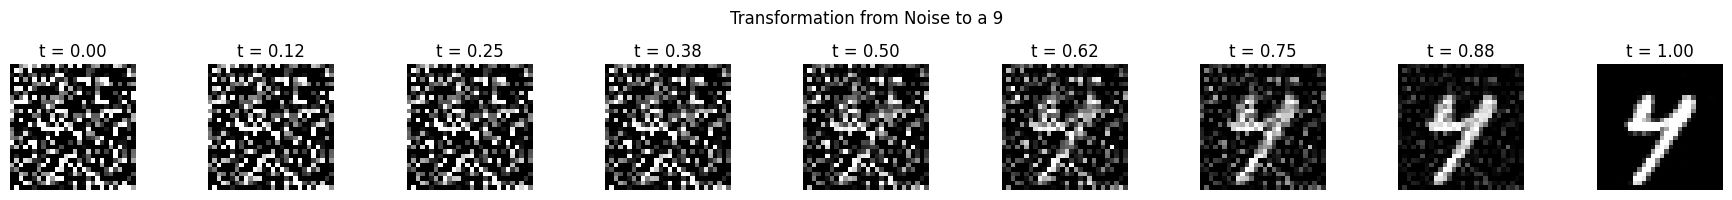

In [ ]:
x = torch.randn(1, 3, 32, 32).to(device)  # Reshape to (batch_size, channels, height, width)
n_steps = 8
time_steps = torch.linspace(0, 1.0, n_steps + 1).to(device)

trajectory = [x.clone()]
with torch.no_grad():
    for i in range(n_steps):
        x = flow.step(x, time_steps[i], time_steps[i + 1])
        trajectory.append(x.clone())

fig, axes = plt.subplots(1, n_steps + 1, figsize=(2*(n_steps+1), 2))
for i, x_i in enumerate(trajectory):
    img = x_i.squeeze().cpu().clamp(0, 1).permute(1,2,0).numpy()  # Remove channel dimension and reshape
    axes[i].imshow(img)
    axes[i].set_title(f"t = {time_steps[i]:.2f}")
    axes[i].axis('off')

plt.suptitle("Transformation from Noise to a CIFAR-10 Cat")
plt.tight_layout()
plt.show()